# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import tensorflow as tf
%matplotlib inline


In [2]:
dataset = get_dataset("data/processed_data/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/processed_data/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/processed_data/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2021-10-12 19:04:52.899870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:04:52.903545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:04:52.903784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:04:52.919947: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch, ax, key_counter, color_map):
    """
    This function takes a batch from the dataset and display the image with
    the associated bounding boxes.
    """
    x = key_counter % 2
    y = key_counter % 5
    image = batch['image'].numpy().astype("uint8")

    # Display data as an image, i.e., on a 2D regular raster
    ax[x, y].imshow(image)

    bboxes = batch['groundtruth_boxes'].numpy()
    labels = batch['groundtruth_classes'].numpy()
    for bbox, label in zip(bboxes, labels):
        y1, x1, y2, x2 = bbox
        # convert normalized positions to 640x640
        y1 = y1 * 640
        x1 = x1 * 640
        y2 = y2 * 640
        x2 = x2 * 640
        rec = Rectangle((x1, y1), x2 - x1, y2 - y1,
                        facecolor='none', edgecolor=color_map[label])
        ax[x, y].add_patch(rec)

    ax[x, y].axis('off')

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

2021-10-12 19:04:59.734814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


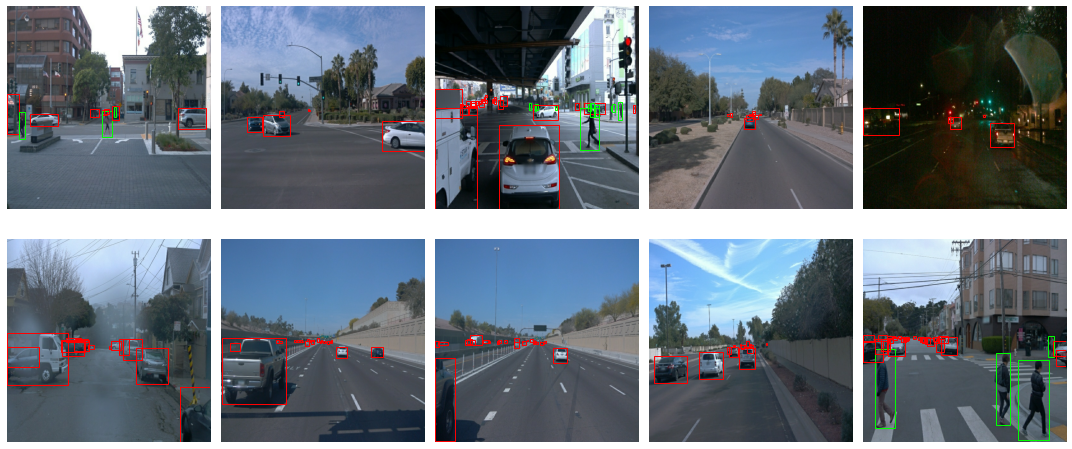

In [4]:
# color mapping of classes
color_map = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
# prepare image plot
f, ax = plt.subplots(2, 5, figsize=(15, 15))
key_counter = 0

# Randomly choose 10 images
for data in dataset.take(10):
    display_instances(data, ax, key_counter, color_map)
    key_counter+=1

plt.tight_layout(rect=[0, 0, 1, 0.65])
plt.show()

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [5]:
def data_analysis(dataset, image_count, file_names, class_total_count, 
                  scene_total_count, bbox_count_in_image, bbox_size_total_count):
    class_keys = [k for k, v in class_total_count.items()]
    scene_keys = [k for k, v in scene_total_count.items()]
    bbox_count_in_image_keys = [k for k, v in bbox_count_in_image.items()]
    bbox_size_keys = [k for k, v in bbox_size_total_count.items()]
    color_encodings = ['blue', 'green', 'red']

    for idx, data in enumerate(dataset):
        if image_count >= 18000:
            break

        filename = data['filename'].numpy().decode('UTF8')
        if filename not in file_names.keys():
            file_names[filename] = True
            
            # check class
            labels = data['groundtruth_classes'].numpy()
            for label in labels:
                if label == 1:
                    class_total_count[class_keys[0]] += 1
                elif label == 2:
                    class_total_count[class_keys[1]] += 1
                else:
                    class_total_count[class_keys[2]] += 1

            # check scene
            gray_image = tf.cast(tf.image.rgb_to_grayscale(data['image']), tf.float32)
            if (tf.reduce_sum(gray_image)/(640*640) > 50):
                scene_total_count[scene_keys[0]] += 1
            else:
                scene_total_count[scene_keys[1]] += 1
            

            bboxes = data['groundtruth_boxes'].numpy()
            # check the number of bboxes
            box_count = len(bboxes)
            if box_count < 10:
                bbox_count_in_image[bbox_count_in_image_keys[0]] += 1
            elif box_count >= 10 and box_count < 30:
                bbox_count_in_image[bbox_count_in_image_keys[1]] += 1
            else:
                bbox_count_in_image[bbox_count_in_image_keys[2]] += 1

            # check bbox size
            for bbox in bboxes:
                y1, x1, y2, x2 = bbox
                y1 = y1 * 640
                x1 = x1 * 640
                y2 = y2 * 640
                x2 = x2 * 640
                area = (y2 - y1) * (x2 - x1)
                if area < 100:
                    bbox_size_total_count[bbox_size_keys[0]] += 1
                elif area >= 100 and area < 10000:
                    bbox_size_total_count[bbox_size_keys[1]] += 1
                else:
                    bbox_size_total_count[bbox_size_keys[2]] += 1

        image_count += 1

    width = 0.5
    # class statistics
    class_count = [v for k, v in class_total_count.items()]
    class_location1 = np.arange(len(class_keys))

    fig1, ax1 = plt.subplots()
    bar1 = ax1.bar(class_location1, class_count, width, color=color_encodings)

    ax1.set_ylabel('Number of Objects')
    ax1.set_title('Object Class')
    ax1.set_xticks(class_location1)
    ax1.set_xticklabels(class_keys)
    ax1.legend()

    fig1.tight_layout()
    plt.show()

    # scene statistics
    scene_count = [v for k, v in scene_total_count.items()]
    scene_location1 = np.arange(len(scene_keys))
    
    fig2, ax2 = plt.subplots()
    bar2 = ax2.bar(scene_location1, scene_count, width, color=color_encodings)

    ax2.set_ylabel('Number of Scenes')
    ax2.set_xticks(scene_location1)
    ax2.set_xticklabels(scene_keys)
    ax2.legend()

    fig2.tight_layout()
    plt.show()

    # bbox count statistics
    bbox_count = [v for k, v in bbox_count_in_image.items()]
    bbox_count_location1 = np.arange(len(bbox_count_in_image_keys))
    
    fig3, ax3 = plt.subplots()
    bar3 = ax3.bar(bbox_count_location1, bbox_count, width, color=color_encodings)

    ax3.set_ylabel('Number of Frames')
    ax3.set_title('Total Bounding Boxes in a Frame')
    ax3.set_xticks(bbox_count_location1)
    ax3.set_xticklabels(bbox_count_in_image_keys)
    ax3.legend()

    fig3.tight_layout()
    plt.show()

    # bbox size statistics
    bbox_size_count = [v for k, v in bbox_size_total_count.items()]
    bbox_size_location1 = np.arange(len(bbox_size_keys))
    
    fig4, ax4 = plt.subplots()
    bar4 = ax4.bar(bbox_size_location1, bbox_size_count, width, color=color_encodings)

    ax4.set_ylabel('Number of Bounding Boxes')
    ax4.set_title('Bounding Box Area')
    ax4.set_xticks(bbox_size_location1)
    ax4.set_xticklabels(bbox_size_keys)
    ax4.legend()

    fig4.tight_layout()
    plt.show()

No handles with labels found to put in legend.


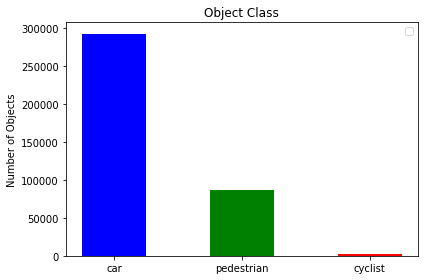

No handles with labels found to put in legend.


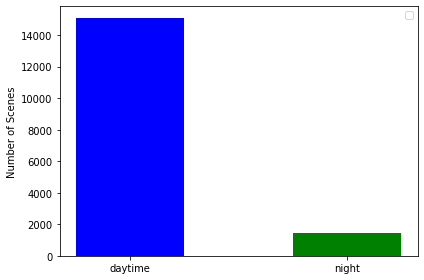

No handles with labels found to put in legend.


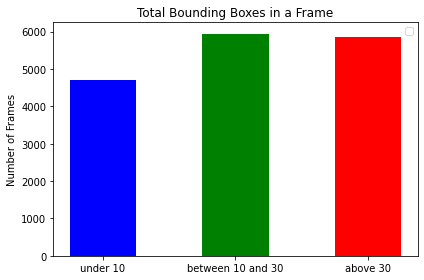

No handles with labels found to put in legend.


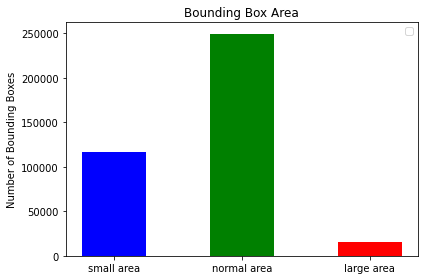

In [6]:
image_count = 0
file_names = {}
class_total_count = {"car": 0, "pedestrian": 0, "cyclist": 0}
scene_total_count = {"daytime": 0, "night": 0}
bbox_count_in_image = {"under 10": 0, "between 10 and 30": 0, "above 30": 0}
bbox_size_total_count = {"small area": 0, "normal area": 0, "large area": 0}
data_analysis(dataset, image_count, file_names, class_total_count, 
              scene_total_count, bbox_count_in_image, bbox_size_total_count)